# Statistics Computation

Notebook addressing some statistics computation around the data extracted from Lommis Airfield.

In [2]:
## IMPORT LIBRARIES ##
import os
import lommis_func
import warnings
import numpy as np
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import Alignment
from datetime import datetime, timedelta
from traffic.core import Traffic, Flight
from traffic.data import airports, opensky, eurofirs
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from cartopy.crs import EuroPP, PlateCarree
from cartes.utils.features import countries
warnings.simplefilter("ignore")

In [140]:
## SELECT YEAR AND MONTH ##
year = 2025
month = 1

## Flight Density Heatmap

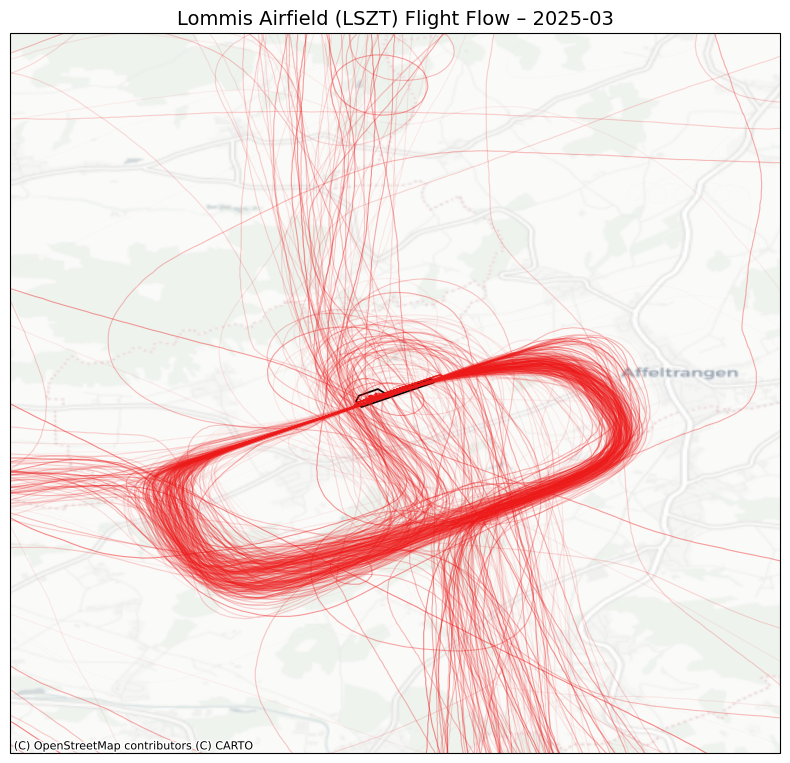

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx
from collections import defaultdict

# 1) Select month
start = f"{year}-{month:02d}-01"
end   = f"{year}-{month:02d}-{pd.Period(start).days_in_month}"

# 2) Filter flights and vicinity
df_all = traff_set.between(start, end).data

min_lon, min_lat, max_lon, max_lat = airports["LSZT"].shape.bounds
pad = 0.035
df = df_all[
    df_all.longitude.between(min_lon - pad, max_lon + pad) &
    df_all.latitude .between(min_lat - pad, max_lat + pad)
]

# 3) Count how often each location is crossed
# Round lat/lon to 4 decimals (~10m precision)
df['lat_rounded'] = df['latitude'].round(4)
df['lon_rounded'] = df['longitude'].round(4)

# Count the frequency of each rounded point
freq = df.groupby(['lat_rounded', 'lon_rounded']).size()
max_freq = freq.max()

# 4) Build figure
fig, ax = plt.subplots(
    figsize=(8, 8), dpi=100,
    subplot_kw=dict(projection=ccrs.PlateCarree())
)
ax.set_extent([min_lon - pad, max_lon + pad, min_lat - pad, max_lat + pad],
              crs=ccrs.PlateCarree())

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ccrs.PlateCarree(), zoom=13)

# 5) Plot each flight with varying alpha depending on how "popular" the path is
for flight in traff_set.between(start, end):
    pts = flight.data.dropna(subset=["longitude", "latitude"]).copy()
    pts['lat_rounded'] = pts['latitude'].round(4)
    pts['lon_rounded'] = pts['longitude'].round(4)

    # Get average frequency of the points along the flight
    merged = pts.merge(freq.rename('count'), left_on=['lat_rounded', 'lon_rounded'], right_index=True)
    mean_freq = merged['count'].mean()
    alpha = 0.01 + 0.8 * (mean_freq / max_freq)  # scale alpha between 0.2 and 1.0

    ax.plot(
        pts.longitude, pts.latitude,
        transform=ccrs.PlateCarree(),
        color="#ED1A1A",
        linewidth=0.8,
        alpha=alpha
    )

# 6) Draw runway
runway = airports["LSZT"].shape
ax.add_geometries(
    [runway], crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black", linewidth=1.25
)

# 7) Final touches
ax.set_title(f"Lommis Airfield (LSZT) Flight Flow – {year}-{month:02d}", color="black", fontsize=14)
plt.tight_layout()
plt.show()


## Circuits Metrics

In [108]:
from tqdm import tqdm
from datetime import timedelta
from collections import Counter

# 1) Select month
start = f"{year}-{month:02d}-01"
end   = f"{year}-{month:02d}-{pd.Period(start).days_in_month}"

# 2) Filter monthly flights
month_set = traff_set.between(start, end)

# 3) Initialize all metrics
total_circuit_time = timedelta(0)
circuit_counts = []
circuit_dates = []
circuit_durations = []
time_of_day_bins = []
weekday_counter = Counter()

for flight in tqdm(month_set):
    try:
        ncircuits, indexes = lommis_func.find_aerodrome_circuits(
            flight, airport=airports["LSZT"], rwy="24", debug=False
        )

        if ncircuits > 0 and indexes is not None:
            circuit_counts.append(ncircuits)
            circuit_dates.append(flight.data.timestamp.iloc[0])  # use flight start

            timestamps = flight.data.timestamp.reset_index(drop=True)

            for start_idx, end_idx in indexes:
                start_time = timestamps.iloc[start_idx]
                end_time = timestamps.iloc[end_idx]
                duration = end_time - start_time

                circuit_durations.append(duration)
                total_circuit_time += duration
                time_of_day_bins.append(start_time.hour)
                weekday_counter[start_time.weekday()] += 1
    except Exception as e:
        continue  # optionally log or count errors

100%|██████████| 225/225 [00:55<00:00,  4.06it/s]


In [60]:
total_flights = len(month_set)
flights_with_circuits = len(circuit_counts)
total_circuits = sum(circuit_counts)
avg_circuits_per_flight = total_circuits / total_flights
avg_circuits_per_detected = total_circuits / flights_with_circuits
total_minutes = total_circuit_time.total_seconds() / 60

print(f"📊 Monthly Circuit Summary – {year}-{month:02d}")
print(f"Total flights analyzed: {total_flights}")
print(f"Flights with circuits: {flights_with_circuits}")
print(f"Total circuits detected: {total_circuits}")
print(f"Average per flight: {avg_circuits_per_flight:.2f}")
print(f"Average per circuit-flight: {avg_circuits_per_detected:.2f}")
print(f"Total circuit time: {total_minutes:.1f} minutes")

📊 Monthly Circuit Summary – 2025-03
Total flights analyzed: 225
Flights with circuits: 63
Total circuits detected: 156
Average per flight: 0.69
Average per circuit-flight: 2.48
Total circuit time: 690.9 minutes


In [70]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl

# Apply LaTeX-style aesthetics
mpl.rcParams.update({
    "text.usetex": False,  # Set to True if LaTeX is installed
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

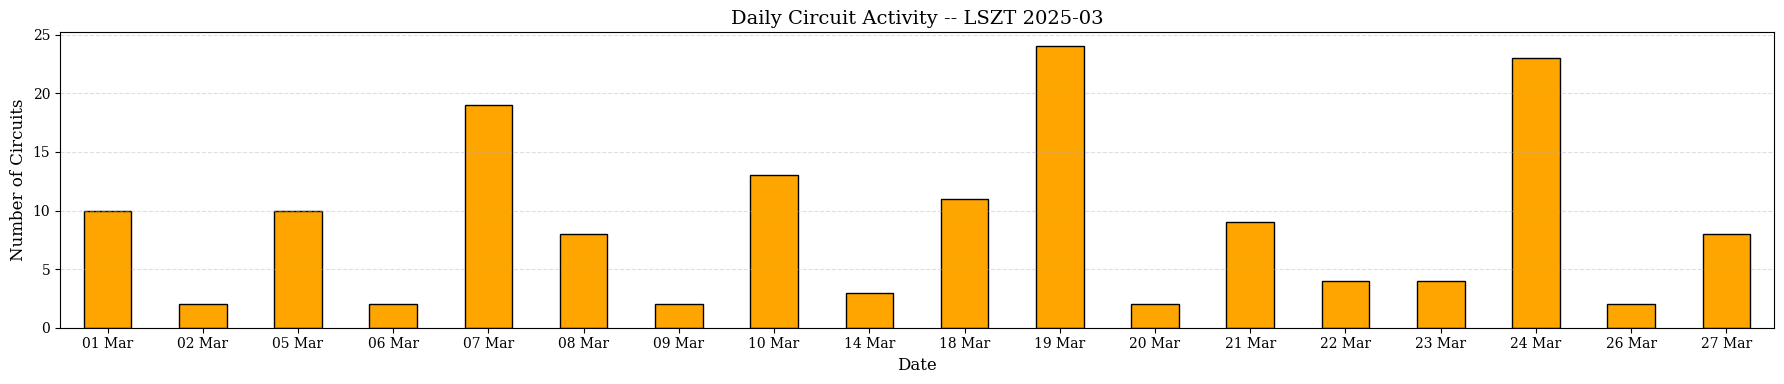

In [88]:
import pandas as pd

df_circuits = pd.DataFrame({'date': [d.date() for d in circuit_dates], 'n': circuit_counts})
circuits_per_day = df_circuits.groupby('date')['n'].sum()

fig, ax = plt.subplots(figsize=(18, 4))
circuits_per_day.plot(kind='bar', ax=ax, color='orange', edgecolor='black')

# Format x-axis with day + abbreviated month
ax.set_xticklabels([d.strftime('%d %b') for d in circuits_per_day.index], rotation=0, ha='center')

ax.set_title(f"Daily Circuit Activity -- LSZT {year}-{month:02d}")
ax.set_ylabel("Number of Circuits")
ax.set_xlabel("Date")
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

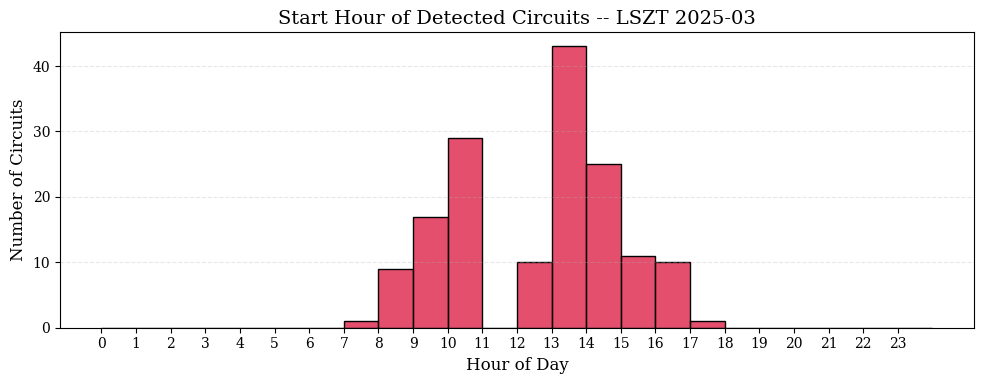

In [91]:
plt.figure(figsize=(10, 4))
sns.histplot(time_of_day_bins, bins=range(0, 25), color='crimson', kde=False, edgecolor='black')

plt.title(f"Start Hour of Detected Circuits -- LSZT {year}-{month:02d}")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Circuits")
plt.xticks(range(0, 24, 1))
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

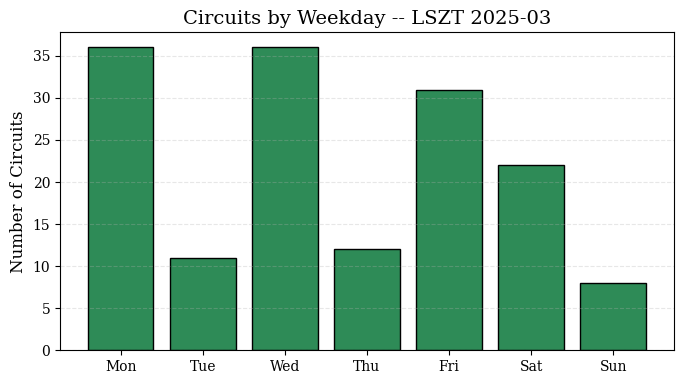

In [92]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
counts = [weekday_counter.get(i, 0) for i in range(7)]

plt.figure(figsize=(7, 4))
plt.bar(days, counts, color="seagreen", edgecolor='black')

plt.title(f"Circuits by Weekday -- LSZT {year}-{month:02d}")
plt.ylabel("Number of Circuits")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## General Metrics

In [ ]:
import pandas as pd

# Load the raw sheet without header
df_raw = pd.read_excel(f"Excel/ARP_LSZT_0{month}{year}.xlsx", sheet_name="DATA", header=None)

# Extract proper header from row 1 and assign to data starting from row 2
header = df_raw.iloc[1]
df = df_raw[2:].copy()
df.columns = header

# Drop completely empty rows
df = df.dropna(how='all')

# Convert numeric fields
for col in ['DAY', 'MONTH', 'YEAR', 'TIME', 'MOUVEMENT', 'PASSENGERS', 'FREIGHT']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter for January 2025
df = df[(df['YEAR'] == 2025) & (df['MONTH'] == 1)]

# Compute general metrics
total_movements = df['MOUVEMENT'].sum()
total_flights = len(df)
departures = len(df[df['ARR_DEP'] == 'D'])
arrivals = len(df[df['ARR_DEP'] == 'A'])

# Group by runway usage
runway_counts = df['RUNWAY'].value_counts()
runway_percent = df['RUNWAY'].value_counts(normalize=True) * 100

runway_stats = pd.DataFrame({
    'Count': runway_counts,
    'Percentage': runway_percent.round(2)
})

# Display results
print("📊 GENERAL METRICS FOR JANUARY 2025 (LSZT)")
print(f"Total flights: {total_flights}")
print(f"Total movements: {total_movements}")
print(f"Departures: {departures}")
print(f"Arrivals: {arrivals}")
print("\nRunway Usage:")
print(runway_stats)


📊 GENERAL METRICS FOR JANUARY 2025 (LSZT)
Total flights: 61
Total movements: 82
Departures: 26
Arrivals: 26

Runway Usage:
        Count  Percentage
RUNWAY                   
24         37       60.66
06         24       39.34


## Generate Report

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime, timedelta
from collections import Counter
from tqdm import tqdm
import lommis_func
from matplotlib.ticker import MultipleLocator

# === CONFIGURATION ===
month_name = datetime(year, month, 1).strftime('%B').upper()
excel_path = f"Excel/ARP_LSZT_{month:02d}{year}.xlsx"
pdf_output = f"Statistics/LSZT_Report_{year}_{month:02d}.pdf"

# === LOAD + CLEAN EXCEL DATA ===
df_raw = pd.read_excel(excel_path, sheet_name="DATA", header=None)
header = df_raw.iloc[1]
df = df_raw[2:].copy()
df.columns = header
df = df.dropna(how='all')
for col in ['DAY','MONTH','YEAR','TIME','MOUVEMENT','PASSENGERS','FREIGHT']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df[(df['YEAR']==year)&(df['MONTH']==month)].copy()
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

# === GENERAL METRICS ===
total_flights      = len(df)
total_movements    = df['MOUVEMENT'].sum()
departures         = (df['ARR_DEP']=='D').sum()
arrivals           = (df['ARR_DEP']=='A').sum()
total_passengers   = df['PASSENGERS'].sum()
total_freight      = df['FREIGHT'].sum()

# === RUNWAY USAGE ===
runway_counts = df['RUNWAY'].value_counts()
runway_percent= (runway_counts/total_movements*100).round(1)
runway_stats  = pd.DataFrame({
    'Runway': runway_counts.index,
    'Count':  runway_counts.values,
    'Pct':    runway_percent.values
})

# === CIRCUIT METRICS ===
filename = f"{year}-{month:02d}-flights.parquet"
file_path = os.path.join("Statistics", filename)

df = pd.read_parquet(file_path)
month_set = Traffic(df)

#convert flights Timestamp to 'datetime64'
month_set.data['timestamp'] = month_set.data['timestamp'].dt.tz_convert(None).astype('datetime64[ns]')
month_set.data['timestamp'] = month_set.data['timestamp'].dt.tz_localize('UTC')

circuit_counts     = []
circuit_dates      = []
time_of_day_bins   = []
weekday_counter    = Counter()
total_circuit_time = timedelta(0)

for flight in tqdm(month_set):
    rwy, rwy_scale = lommis_func.detect_runway(flight, airports["LSZT"], 1.0, 10*1.0)
    extreme1, extreme2, center = lommis_func.retrieve_runway_information(airports["LSZT"], rwy)

    n, idxs = lommis_func.find_aerodrome_circuits(flight,
                                    airport=airports["LSZT"],
                                    rwy=rwy,
                                    scale=rwy_scale,
                                    debug=False)
    if n>0 and idxs:
        circuit_counts.append(n)
        first_ts = flight.data.timestamp.iloc[0]
        circuit_dates.append(first_ts.date())
        stamps = flight.data.timestamp.reset_index(drop=True)
        for s,e in idxs:
            st, en = stamps.iloc[s], stamps.iloc[e]
            total_circuit_time += (en - st)
            time_of_day_bins.append(st.hour)
            weekday_counter[st.weekday()] += 1


flights_with_circuits = len(circuit_counts)
total_circuits        = sum(circuit_counts)
total_minutes         = total_circuit_time.total_seconds()/60
df_circ               = pd.DataFrame({'date': circuit_dates, 'n': circuit_counts})
circuits_per_day      = df_circ.groupby('date')['n'].sum()

# === BUILD & SAVE PDF ===
with PdfPages(pdf_output) as pdf:
    fig = plt.figure(figsize=(11.7,8.3))  # A4 landscape
    fig.suptitle(f"STATISTIC REPORT LOMMIS AIRFIELD (LSZT)\n{month_name} {year}",
                 fontsize=22, fontweight='bold', y=0.96)
    gs = fig.add_gridspec(3,4, top=0.92, bottom=0.05, left=0.05, right=0.98,
                          hspace=0.5, wspace=0.4)
    
    # Summary with colored numbers
    ax0 = fig.add_subplot(gs[0,0:2]); ax0.axis('off')
    summary_text = (
        f"Total Flights:      {total_flights}\n"
        f"Total Movements:    {total_movements}\n"
        f"Departures:         {departures}\n"
        f"Arrivals:           {arrivals}\n"
        #f"Total Passengers:   {total_passengers}\n"
        #f"Total Freight (kg): {total_freight}\n"
        f"Number of Circuits:     {total_circuits}\n"
        f"Flights w/ Circuits:{flights_with_circuits}\n"
        f"Total Circuit Time: {total_minutes:.1f} min"
    )
    # apply colors
    for i, line in enumerate(summary_text.split('\n')):
        key, val = line.split(':')
        ax0.text(0, 0.65-0.1*i, f"{key}:", fontsize=12, fontweight='bold')
        ax0.text(0.6, 0.65-0.1*i, val.strip(), fontsize=12, color='C1', fontweight='bold')
    
    labels = [f"RWY {r}" for r in runway_stats['Runway']]

    # Runway usage pie
    ax1 = fig.add_subplot(gs[0,2:4])
    wedges, texts, autotexts = ax1.pie(
        runway_stats['Pct'],
        labels=[f"RWY {r}" for r in runway_stats['Runway']],
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('pastel'),
        textprops={'fontsize':12},
        wedgeprops={'edgecolor':'black', 'linewidth':1}
    )
    ax1.set_title("Runway Usage", fontsize=16, fontweight='bold')

    pos = ax1.get_position()
    ax1.set_position([pos.x0, pos.y0 - 0.065, pos.width, pos.height])
    
    # Daily circuits (full width bottom)
    ax2 = fig.add_subplot(gs[2,0:4])
    circuits_per_day.plot(kind='bar', ax=ax2,
                          color='C0', edgecolor='black')
    ax2.set_title("Daily Circuits", fontsize=16, fontweight='bold')
    ax2.set_ylabel("Amount of Circuits", fontsize=12)
    ax2.set_xticklabels([d.strftime('%d %b') for d in circuits_per_day.index],
                        rotation=0, fontsize=10)
    ax2.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Circuit start hour
    ax3 = fig.add_subplot(gs[1,0:2])
    sns.histplot(time_of_day_bins, bins=range(25),
                 edgecolor='black', ax=ax3, color='C2')
    ax3.set_title("Circuit Start Hour", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Hour", fontsize=12)
    ax3.set_ylabel("Amount of Circuits", fontsize=12)
    ax3.grid(axis='y', linestyle='--', alpha=0.3)
    ax3.xaxis.set_major_locator(MultipleLocator(1))
    ax3.set_xlim(0, 24)
    
    # Circuits by weekday
    days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    counts = [weekday_counter[i] for i in range(7)]
    ax4 = fig.add_subplot(gs[1,2:4])
    sns.barplot(x=days, y=counts, color='C3', edgecolor='black', ax=ax4)
    ax4.set_title("Circuits by Weekday", fontsize=14, fontweight='bold')
    ax4.set_ylabel("Amount of Circuits", fontsize=12)
    ax4.grid(axis='y', linestyle='--', alpha=0.3)
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

print(f"✅ PDF report saved to {pdf_output}")

100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


✅ PDF report saved to Statistics/LSZT_Report_2025_01.pdf
